# Forecast Ghana GDP

Import dependencies.

In [59]:
import pandas as pd

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Load and visualize data

Load data.

In [3]:
data = pd.read_csv('../../data/Task10_ghana_gdp.csv', index_col='year', parse_dates=['year'])
data

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Visualize the original time series.

<Axes: title={'center': 'Ghana GDP in USD'}, xlabel='year'>

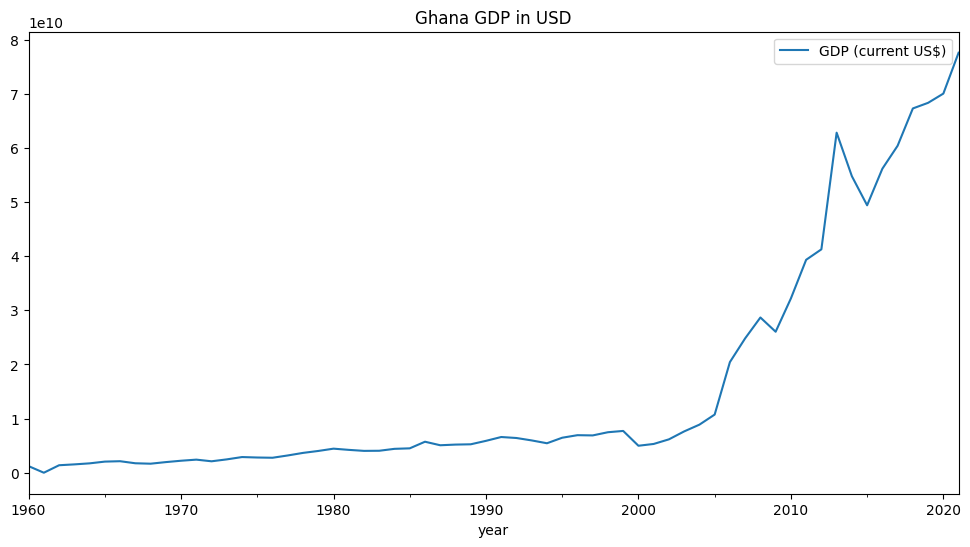

In [8]:
data.plot(
    figsize=(12,6),
    title='Ghana GDP in USD'
)

Perform and visualize a seasonal decomposition.

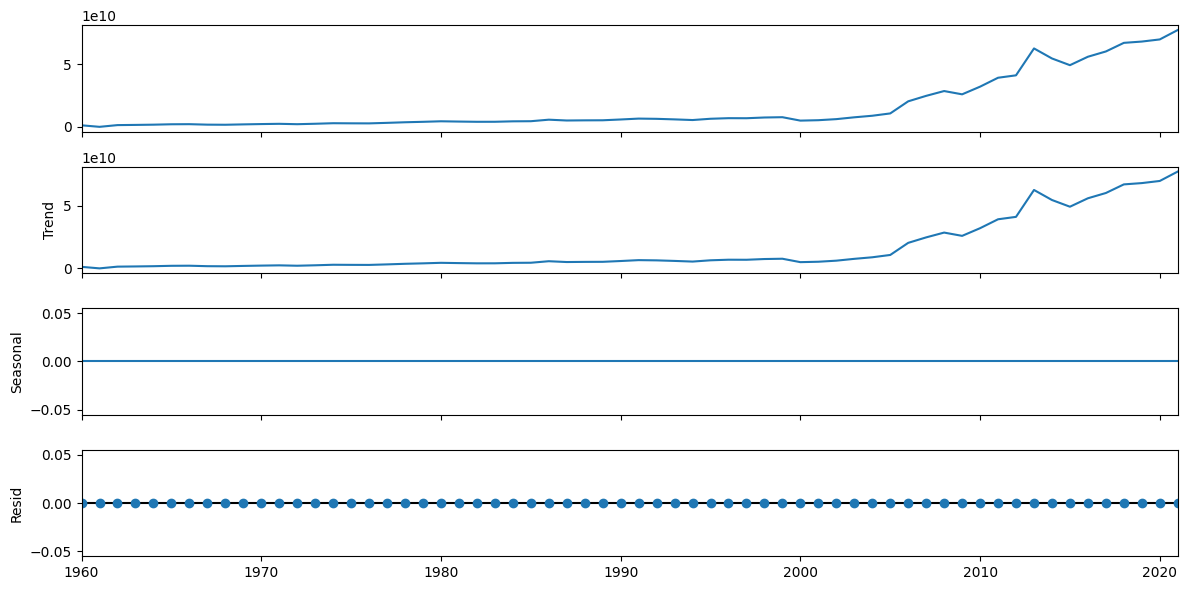

In [22]:
plt.rcParams['figure.figsize'] = 12, 6

decomposition = seasonal_decompose(data)
decomposition.plot()
plt.show()


There is a slight upwards trend since 2000.

There is no seasonality.

### Split train and test data

In [29]:
# Take the years up to 2018 as train data. The remaining three years are taken as test data.
data_train = data[:-3]
data_test = data[-3:]

### Moving average

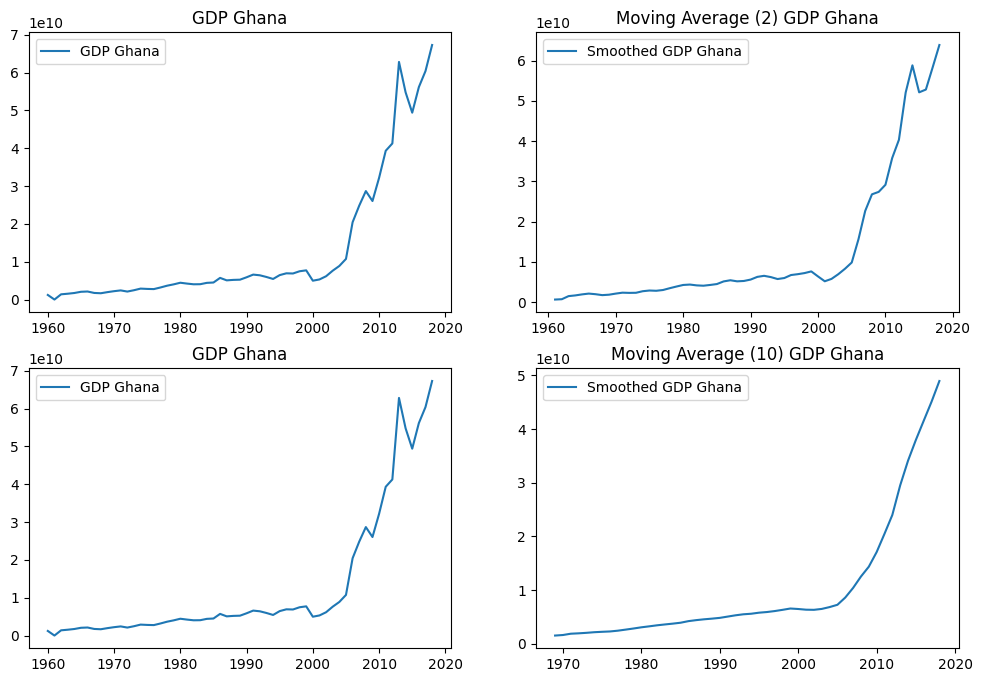

In [45]:
plt.rcParams['figure.figsize'] = 12, 8

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(data_train['GDP (current US$)'], label='GDP Ghana')
ax[0, 0].set_title('GDP Ghana')
ax[0, 0].legend()

ax[0, 1].plot(data_train['GDP (current US$)'].rolling(window=2).mean(), label='Smoothed GDP Ghana')
ax[0, 1].set_title('Moving Average (2) GDP Ghana')
ax[0, 1].legend()

ax[1, 0].plot(data_train['GDP (current US$)'], label='GDP Ghana')
ax[1, 0].set_title('GDP Ghana')
ax[1, 0].legend()

ax[1, 1].plot(data_train['GDP (current US$)'].rolling(window=10).mean(), label='Smoothed GDP Ghana')
ax[1, 1].set_title('Moving Average (10) GDP Ghana')
ax[1, 1].legend()

The oveall upwards trend after the year 2000 was clear on the original data. With moving average and the window equal to 10 it is unambiguous.

### Stationarity and ARMA/ARIMA models

In [49]:
def do_adfuller(df):
    result = adfuller(df['GDP (current US$)'])

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")

do_adfuller(data_train)

ADF Statistic: 0.6529066974885374
p-value: 0.9888496277665573
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


The statistics are higher than any of the critical values. Will differentiate the data and try again.

In [50]:
do_adfuller(data_train.diff().dropna())

ADF Statistic: -1.670248303832079
p-value: 0.4465029329713883
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599


The statistics are still higher that any of the critical values. Will differentiate the data twice and try again.

In [51]:
do_adfuller(data_train.diff(2).dropna())

ADF Statistic: -3.5836708658260332
p-value: 0.00608098975387688
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


After differentiating the data twice we get a stationary time series. This means that the parameter d for ARIMA is equal to 2.

We proceed with building correlograms for autocorrelation and partial autocorrelation.

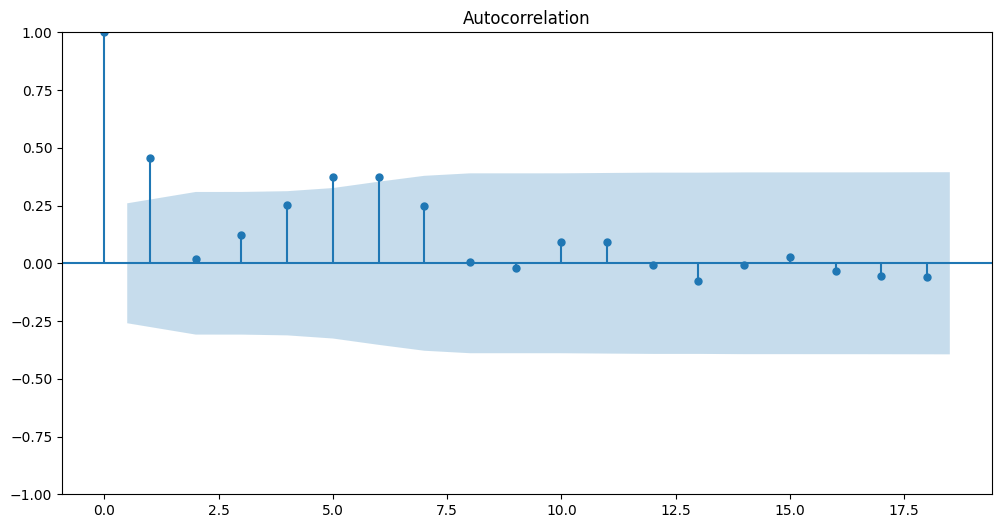

In [55]:
plt.rcParams['figure.figsize'] = 12, 6

plot_acf(data_train.diff(2).dropna())
plt.show()

Parameter q=1, since it is the last lag which is significantly different from 0.

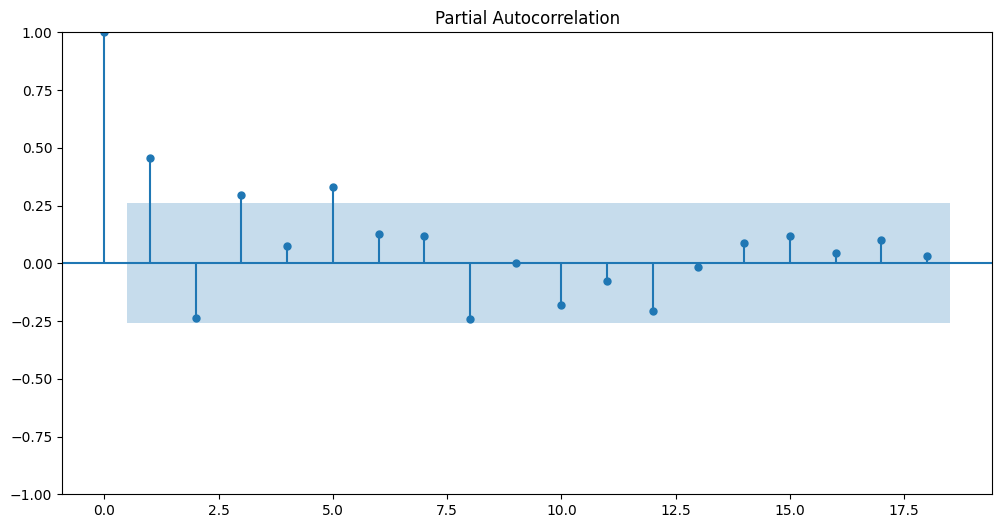

In [58]:
plot_pacf(data_train.diff(2).dropna())
plt.show()

Parameter p=1, since it is the last lag which is significantly different from 0.

Since d <> 0, we proceed with building the ARIMA model witht parameters defined as follows:
* p=1
* d=2
* q=1

In [61]:
arima_model = ARIMA(data_train['GDP (current US$)'], order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/dmitriygolubitskiy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/dmitriygolubitskiy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/dmitriygolubitskiy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 19 Feb 2025   AIC                           2684.416
Time:                        20:55:24   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+56. Standard errors may be unstable.
"""